In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import re
import fbprophet as ph
sns.set()

/home/joaoholz/miniconda3/envs/tslestat/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## clean data function

In [2]:
def remove_episodio(string):
    value = re.search('\(Episódio', string).start()
    string = string[:(value-1)]
    return string

def remove_temporada(string):
    value = re.search(': Temporada', string).start()
    string = string[:value]
    return string

def try_remove_episodio(string):
    try:
        return remove_episodio(string)
    except:
        return string
    
def try_remove_temporada(string):
    try:
        return remove_temporada(string)
    except:
        return string
    
    
def create_date_range_dataframe(start_date,end_date,freq='1H', column_name='hours'):
    df = pd.DataFrame({column_name: pd.date_range(start_date, end_date, freq=freq, closed='left')})
    return df

def create_time_series_dataframe(start_date,end_date,freq='1H',datetime_column_name='hours',
                          weekday_dummies=True,
                          month_dummies=True,
                          hour_dummies=True):
    df = create_date_range_dataframe(start_date,end_date,freq=freq,column_name=datetime_column_name)
    if weekday_dummies:
        df = pd.concat([df,make_dummies(pd.Series(df.iloc[:,0].dt.weekday, name = 'weekday_dummie'))],axis=1)
    if month_dummies:
        df = pd.concat([df,make_dummies(pd.Series(df.iloc[:,0].dt.month, name = 'month_dummie'))],axis=1)
    if hour_dummies:
        df = pd.concat([df,make_dummies(pd.Series(df.iloc[:,0].dt.hour, name = 'hour_dummie'))],axis=1)
   
    df.index =  df[datetime_column_name]
    df = df.iloc[:,1:]
    return df

def make_count_df(df,ts_column,column_count = 'title_clean'):
    df[ts_column] = pd.to_datetime(df[ts_column])
    x = df.groupby(ts_column).count()
    x = x.groupby(pd.Grouper(freq='D')).count()[column_count]
    return pd.DataFrame(x)

In [3]:
ip_addres = pd.read_csv('netflix_data/IP_ADDRESSES/IpAddressesStreaming.csv')

In [4]:
ip_addres.Ts = pd.to_datetime(ip_addres.Ts)

In [5]:
ip_addres.Ts.describe()

/tmp/ipykernel_44111/2879480625.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  ip_addres.Ts.describe()


count                                  992
unique                                 992
top       2023-05-02 12:18:32.681000+00:00
freq                                     1
first     2020-01-15 22:56:26.205000+00:00
last      2023-05-02 12:18:32.681000+00:00
Name: Ts, dtype: object

Como temos a conta da netflix por mais tempo que 2020. logo suponho que a netflix sobreescreve o tempo pra tras. 
Como não lemos mais sobre o export vamos considerar que apenas os dados de pesquisa e visualização abaixo precedem 3 anos de coleta.

In [6]:
clickstream = pd.read_csv('netflix_data/CLICKSTREAM/Clickstream.csv')

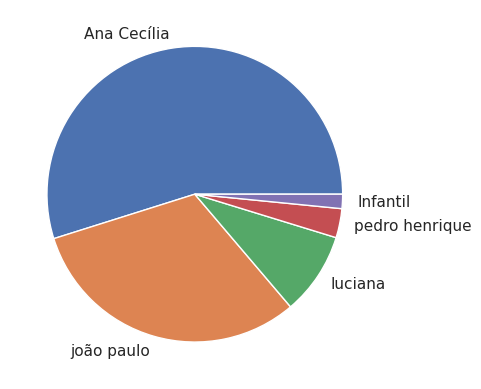

In [7]:
temp = clickstream['Profile Name'].value_counts()
_ = plt.pie(temp.values,labels=temp.index)
temp = None

In [8]:
x = clickstream.groupby(['Navigation Level','Profile Name']).count()
x.sort_values('Click Utc Ts',ascending=False).head(20)

Source  Referrer Url  Webpage Url  \
Navigation Level Profile Name                                        
playback         joão paulo        1622          1380         1388   
                 Ana Cecília       1533             0            0   
movieDetails     Ana Cecília       1265             0            0   
postPlay         Ana Cecília       1118             0            0   
browseTitles     Ana Cecília        703             0            0   
                 joão paulo         474           113          378   
profilesGate     Ana Cecília        393             0            0   
search           joão paulo         332           308          308   
screenSaver      Ana Cecília        309             0            0   
movieDetails     joão paulo         277            31           41   
playback         luciana            254             0            0   
profilesGate     joão paulo         223             1          135   
movieDetails     luciana            206             0            0   
postPlay         luciana            194             0            0   
                 joão paulo         151             4            4   
browseTitles     luciana            137             0            0   
movieDetails     pedro henrique      98             0            0   
browseTitles     pedro henrique      83             0            0   
profilesGate     luciana             82             0            0   
episodesSelector Ana Cecília         67             0            0   

                                 Click Utc Ts  
Navigation Level Profile Name                  
playback         joão paulo              1622  
                 Ana Cecília             1533  
movieDetails     Ana Cecília             1265  
postPlay         Ana Cecília             1118  
browseTitles     Ana Cecília              703  
                 joão paulo               474  
profilesGate     Ana Cecília              393  
search           joão paulo               332  
screenSaver      Ana Cecília              309  
movieDetails     joão paulo               277  
playback         luciana                  254  
profilesGate     joão paulo               223  
movieDetails     luciana                  206  
postPlay         luciana                  194  
                 joão paulo               151  
browseTitles     luciana                  137  
movieDetails     pedro henrique            98  
browseTitles     pedro henrique            83  
profilesGate     luciana                   82  
episodesSelector Ana Cecília               67

In [9]:
streaming = pd.read_csv('netflix_data/IP_ADDRESSES/IpAddressesStreaming.csv')
streaming['conta1'] = 1
column = 'Region Code Display Name'
temp = streaming[column]

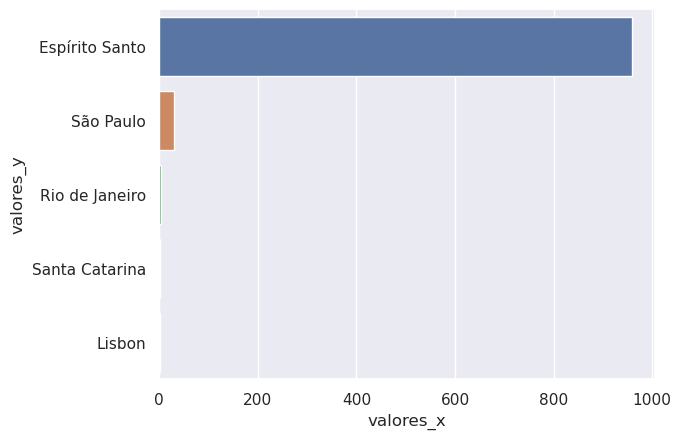

In [10]:
## need x
df_plot = pd.DataFrame()
df_plot['valores_x'] = pd.DataFrame(temp.value_counts().values)
df_plot['valores_y'] = pd.DataFrame(temp.value_counts().index)
_ = sns.barplot(data = df_plot, x = 'valores_x',y = 'valores_y')

In [11]:
# streaming, ip_addres,clickstream
searchHist = pd.read_csv('netflix_data/CONTENT_INTERACTION/SearchHistory.csv')
viewingAc = pd.read_csv('netflix_data/CONTENT_INTERACTION/ViewingActivity.csv')

In [12]:
#search
devices_people = searchHist.groupby(['Profile Name','Device']).count()
devices_people.sort_values('Utc Timestamp',ascending=False).head(10)

,,Country Iso Code,Is Kids,Query Typed,Displayed Name,Action,Section,Utc Timestamp
Profile Name,Device,,,,,,,
Ana Cecília,Smart TV,572,572,509,335,572,367,572
pedro henrique,Smart TV,498,498,473,434,498,250,498
luciana,Smart TV,180,180,121,95,180,105,180
joão paulo,HTML 5,185,185,185,93,185,73,123
Ana Cecília,PS4,181,181,174,116,181,0,97
joão paulo,Smart TV,81,81,71,69,81,81,81
pedro henrique,Android Phone,112,112,112,55,112,3,77
Ana Cecília,iPhone,52,52,49,33,52,17,50
luciana,PS4,137,137,134,103,137,0,42


In [13]:
cross_df = searchHist[['Device','Profile Name']]

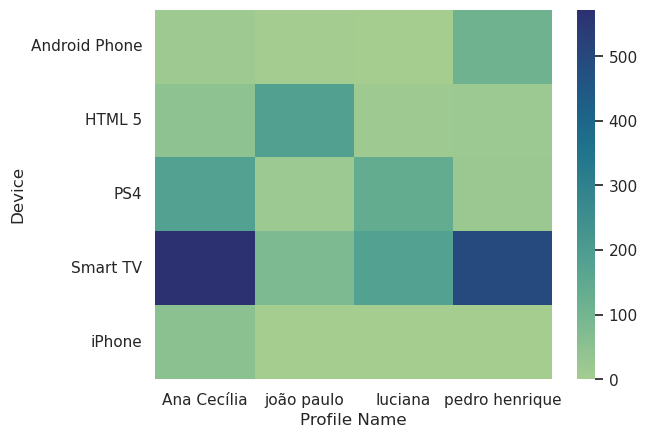

In [14]:
temp = pd.crosstab(cross_df['Device'],cross_df['Profile Name']).drop('Infantil',axis=1)
_ = sns.heatmap(temp,cmap='crest')

In [15]:
tests = ['Julie and the Phantoms: Temporada 1: O que não falei para Emily (Episódio 8)',
'Julie and the Phantoms: Temporada 1: Carreira solo (Episódio 3)',
'Julie and the Phantoms: Temporada 1: À beira da perfeição (Episódio 7)',
'Julie and the Phantoms: Temporada 1: À beira da perfeição']
list(map(lambda x: (try_remove_temporada(x)),tests))

['Julie and the Phantoms',
 'Julie and the Phantoms',
 'Julie and the Phantoms',
 'Julie and the Phantoms']

In [16]:
viewingAc['title_clean'] = viewingAc['Title'].apply(try_remove_episodio).apply(try_remove_temporada)
temp = viewingAc[['Profile Name','title_clean','Country']]
temp.groupby(['Profile Name','title_clean']).count().sort_values('Country',ascending=False).head(50)

Country
Profile Name   title_clean                           
Ana Cecília    Brooklyn Nine-Nine                1210
joão paulo     How I Met Your Mother             1020
               Friends                            927
Ana Cecília    Modern Family                      854
joão paulo     BoJack Horseman                    767
               Dr. House                          752
               The Office (U.S.)                  586
               Rick and Morty                     560
               Brooklyn Nine-Nine                 553
Ana Cecília    Julie and the Phantoms             543
joão paulo     Apenas um Show                     383
pedro henrique Arrow                              372
Ana Cecília    Barbie Life in the Dreamhouse      367
               Suits                              362
               That '70s Show                     305
joão paulo     Family Guy                         302
pedro henrique Brooklyn Nine-Nine                 282
joão paulo     Seinfeld                           281
               Sons of Anarchy                    280
pedro henrique That '70s Show                     273
               The Walking Dead                   273
joão paulo     Gravity Falls                      262
Ana Cecília    Brilhante Victória                 258
pedro henrique The Flash                          244
Ana Cecília    The Vampire Diaries                241
joão paulo     That '70s Show                     235
Ana Cecília    Lucifer                            221
pedro henrique How I Met Your Mother              220
luciana        Era uma vez                        217
pedro henrique The 100                            213
Ana Cecília    Pretty Little Liars                191
joão paulo     Neon Genesis Evangelion            178
luciana        Elementary                         175
pedro henrique Vikings                            174
Ana Cecília    Scandal                            167
joão paulo     Hora de Aventura                   165
luciana        Grimm                              165
joão paulo     Naruto Shippuden                   152
pedro henrique Arrested Development               151
joão paulo     Um maluco no pedaço                150
luciana        Ponto Cego                         148
joão paulo     Hunter X Hunter (2011)             144
Ana Cecília    Três é Demais                      143
pedro henrique Star Wars: The Clone Wars          141
joão paulo     Gotham                             137
Ana Cecília    The Originals                      137
               Gossip Girl                        127
luciana        Outlander                          121
joão paulo     The Seven Deadly Sins              120
luciana        Riverdale                          113

## Creating a time series dataframe

In [17]:
viewingAc['Start Time'] = pd.to_datetime(viewingAc['Start Time'])

In [18]:
df = create_date_range_dataframe('2016-01-01', '2024-01-01','D','day')
x = make_count_df(viewingAc,'Start Time', 'title_clean')
df = df.merge(x, 
         how='left',
         left_on='day',
         right_on='Start Time')

x = make_count_df(searchHist,'Utc Timestamp','Profile Name')
df = df.merge(x, 
         how='left',
         left_on='day',
         right_on='Utc Timestamp')

streaming.Ts = pd.to_datetime(streaming.Ts).dt.tz_localize(None).dt.date
x = make_count_df(streaming,'Ts','Country')
df = df.merge(x, 
         how='left',
         left_on='day',
         right_on='Ts')

df = df.fillna(0)
df.columns = ['date','View','Search','streaming']

clickstream['Click Utc Ts'] = pd.to_datetime(clickstream['Click Utc Ts'])
x = make_count_df(clickstream,'Click Utc Ts','Profile Name')
df = df.merge(x, 
         how='left',
         left_on='date',
         right_on='Click Utc Ts')
df.columns = ['date','View','Search','streaming','clickstream']
df = df.fillna(0)


/tmp/ipykernel_44111/3840948610.py:25: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  df = pd.DataFrame({column_name: pd.date_range(start_date, end_date, freq=freq, closed='left')})


In [19]:
model_df = df[(df.date>'2020-01-01') & (df.date<'2023-01-01')]
model_df.columns = ['DS','Y','Search','streaming','clickstream']

In [20]:
model_df.index = model_df.DS

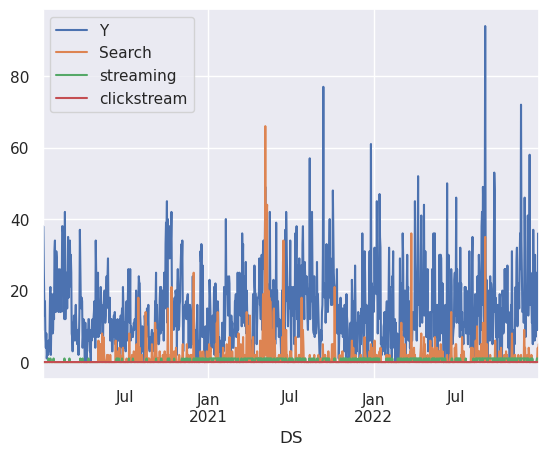

In [21]:
_ = model_df.iloc[:,1:].plot()

In [24]:
columns = ['Start Time','Profile Name']
x = viewingAc[columns]
x['Start Time'] = pd.to_datetime(x['Start Time'])
x['Dia Semana'] = x['Start Time'].dt.weekday
x['Hora'] = x['Start Time'].dt.hour

/tmp/ipykernel_44111/1747873898.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['Start Time'] = pd.to_datetime(x['Start Time'])
/tmp/ipykernel_44111/1747873898.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['Dia Semana'] = x['Start Time'].dt.weekday
/tmp/ipykernel_44111/1747873898.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

<AxesSubplot: xlabel='Dia Semana', ylabel='Hora'>

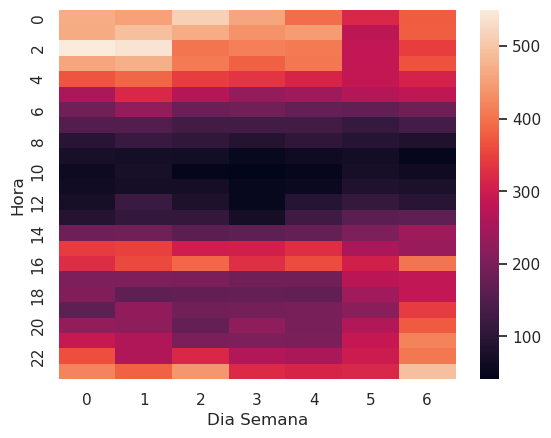

In [25]:
sns.heatmap(pd.crosstab(x.Hora,x['Dia Semana']))

<AxesSubplot: xlabel='Dia Semana', ylabel='Hora'>

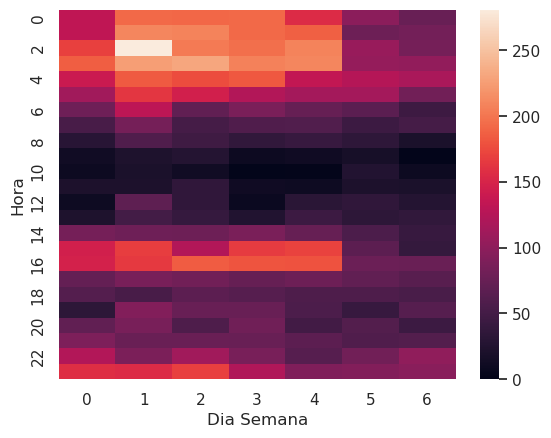

In [26]:
ana = x[x['Profile Name']=='Ana Cecília']
sns.heatmap(pd.crosstab(ana.Hora,ana['Dia Semana']))

In [27]:
x['Profile Name'].unique()

array(['Ana Cecília', 'Infantil', 'joão paulo', 'luciana',
       'pedro henrique'], dtype=object)

<AxesSubplot: xlabel='Dia Semana', ylabel='Hora'>

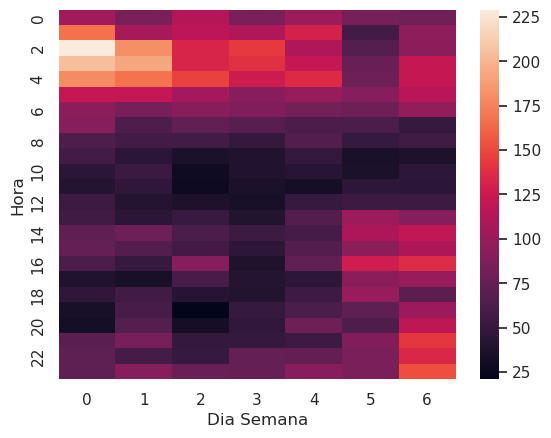

In [28]:
joao = x[x['Profile Name']=='joão paulo']
sns.heatmap(pd.crosstab(joao.Hora,joao['Dia Semana']))

<AxesSubplot: xlabel='Dia Semana', ylabel='Hora'>

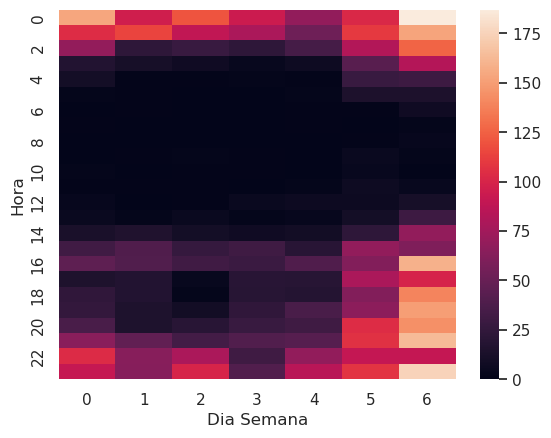

In [29]:
luciana = x[x['Profile Name']=='luciana']
sns.heatmap(pd.crosstab(luciana.Hora,luciana['Dia Semana']))

In [30]:
x.columns = ['date_time'] + list(x.columns[1:])

In [142]:
x.plot('Profile Name')

In [31]:
luciana['Start Time'] = luciana['Start Time'].dt.date

/tmp/ipykernel_44111/1967592910.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  luciana['Start Time'] = luciana['Start Time'].dt.date


In [32]:
x['date_time'] = x['date_time'].dt.date

/tmp/ipykernel_44111/1003025097.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['date_time'] = x['date_time'].dt.date


In [33]:
x

,date_time,Profile Name,Dia Semana,Hora
0,2023-04-28,Ana Cecília,4,6
1,2023-04-28,Ana Cecília,4,5
2,2023-04-28,Ana Cecília,4,4
3,2023-04-28,Ana Cecília,4,4
4,2023-04-27,Ana Cecília,3,5
...,...,...,...,...
40333,2016-01-22,pedro henrique,4,3
40334,2016-01-22,pedro henrique,4,3
40335,2016-01-22,pedro henrique,4,2
40336,2016-01-22,pedro henrique,4,1


In [42]:
new_df = x.iloc[:,:2].groupby(['date_time','Profile Name']).size().unstack().fillna(0)

<AxesSubplot: xlabel='date_time'>

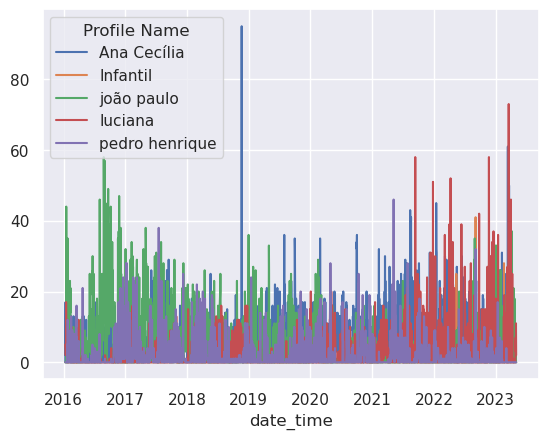

In [46]:
new_df.plot()

In [61]:
new_df.index.resample('M')

AttributeError: 'Index' object has no attribute 'resample'

In [49]:
new_df[].resample('M').mean().plot()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'